In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

LOADING SIMULATION RESULTS
✅ Loaded 2,185 hours of simulation data
   Period: 2024-10-01 00:00:00 to 2024-12-31 00:00:00
   Total days: 92

1. BATTERY STATE OF CHARGE OVER TIME


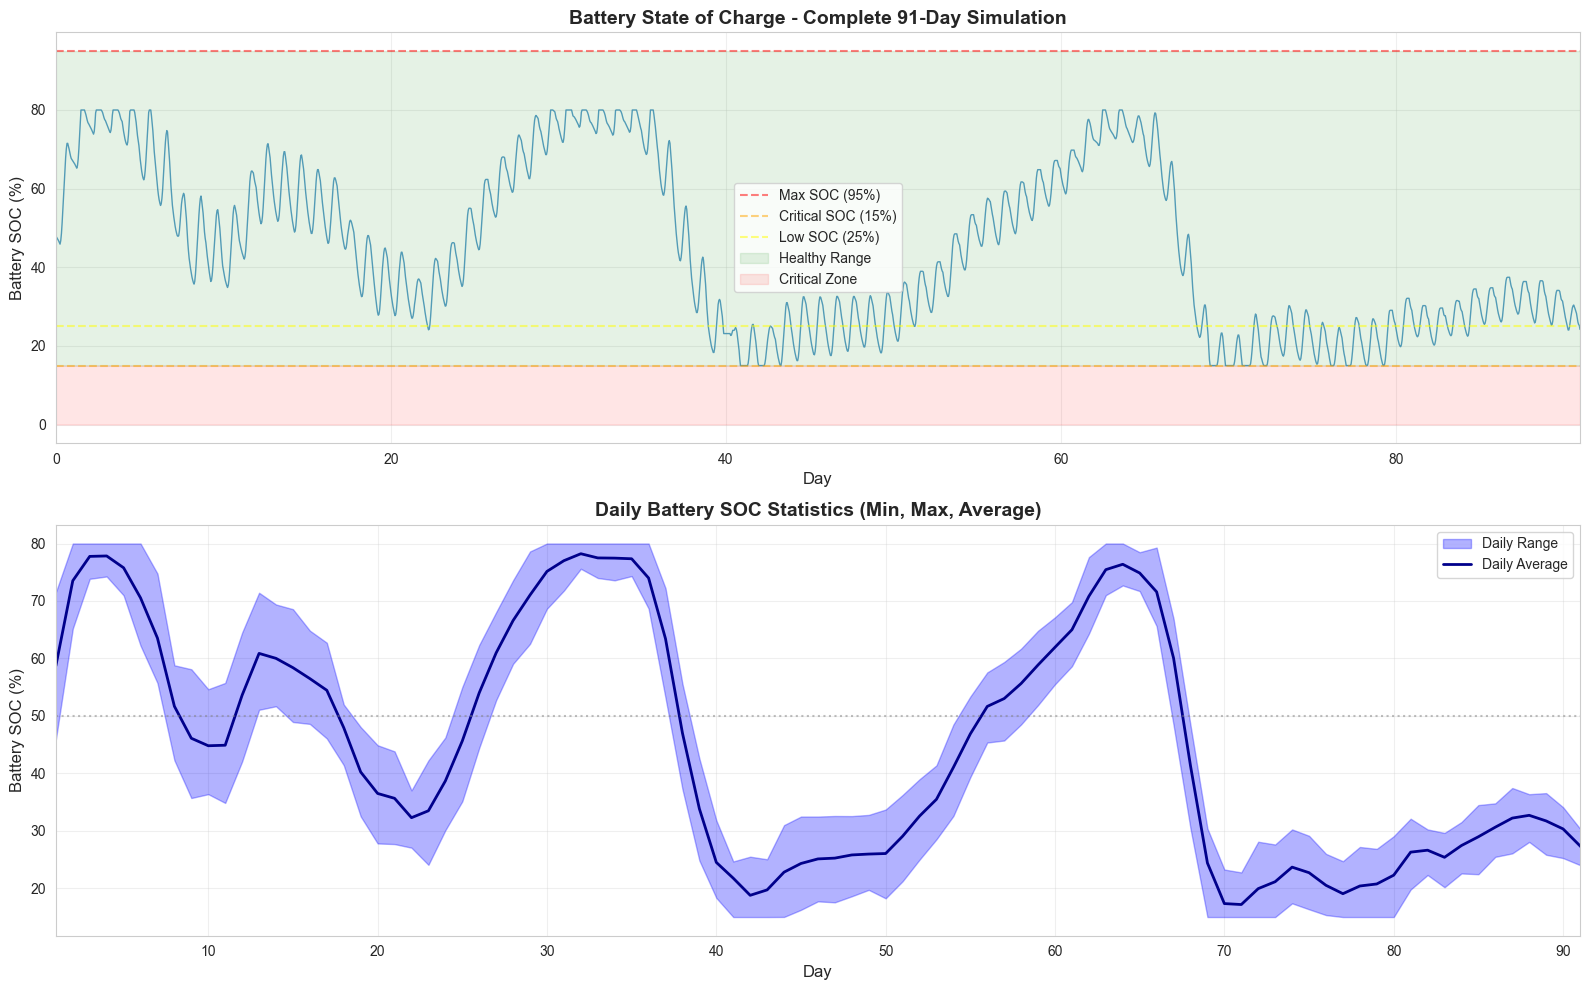

   Min SOC reached: 15.0%
   Max SOC reached: 80.0%
   Average SOC: 45.1%
   Days with SOC < 20%: 24


In [12]:
"""
OFF-GRID ENERGY SYSTEM ANALYSIS & VISUALIZATION
================================================
Analyzes the 91-day simulation results and creates comprehensive visualizations
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

# ============================================================================
# LOAD DATA
# ============================================================================
print("=" * 80)
print("LOADING SIMULATION RESULTS")
print("=" * 80)

results_path = '../../results/phase_2_offgrid_simulation.csv'
df = pd.read_csv(results_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day'] = (df.index // 24) + 1
df['date'] = df['timestamp'].dt.date

print(f"✅ Loaded {len(df):,} hours of simulation data")
print(f"   Period: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"   Total days: {df['day'].max()}")

# ============================================================================
# 1. BATTERY SOC OVER TIME (91 DAYS)
# ============================================================================
print("\n" + "=" * 80)
print("1. BATTERY STATE OF CHARGE OVER TIME")
print("=" * 80)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Full timeline
ax1.plot(df.index / 24, df['battery_soc_percent'], linewidth=1, color='#2E86AB', alpha=0.8)
ax1.axhline(y=95, color='red', linestyle='--', label='Max SOC (95%)', alpha=0.5)
ax1.axhline(y=15, color='orange', linestyle='--', label='Critical SOC (15%)', alpha=0.5)
ax1.axhline(y=25, color='yellow', linestyle='--', label='Low SOC (25%)', alpha=0.5)
ax1.fill_between(df.index / 24, 15, 95, alpha=0.1, color='green', label='Healthy Range')
ax1.fill_between(df.index / 24, 0, 15, alpha=0.1, color='red', label='Critical Zone')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Battery SOC (%)', fontsize=12)
ax1.set_title('Battery State of Charge - Complete 91-Day Simulation', fontsize=14, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 91)

# Daily min/max/avg
daily_stats = df.groupby('day').agg({
    'battery_soc_percent': ['min', 'max', 'mean']
}).reset_index()
daily_stats.columns = ['day', 'min_soc', 'max_soc', 'avg_soc']

ax2.fill_between(daily_stats['day'], daily_stats['min_soc'], daily_stats['max_soc'], 
                  alpha=0.3, color='blue', label='Daily Range')
ax2.plot(daily_stats['day'], daily_stats['avg_soc'], linewidth=2, color='darkblue', label='Daily Average')
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Battery SOC (%)', fontsize=12)
ax2.set_title('Daily Battery SOC Statistics (Min, Max, Average)', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 91)

plt.tight_layout()
plt.show()

print(f"   Min SOC reached: {df['battery_soc_percent'].min():.1f}%")
print(f"   Max SOC reached: {df['battery_soc_percent'].max():.1f}%")
print(f"   Average SOC: {df['battery_soc_percent'].mean():.1f}%")
print(f"   Days with SOC < 20%: {(daily_stats['min_soc'] < 20).sum()}")


2. PRODUCTION VS CONSUMPTION CORRELATION ANALYSIS


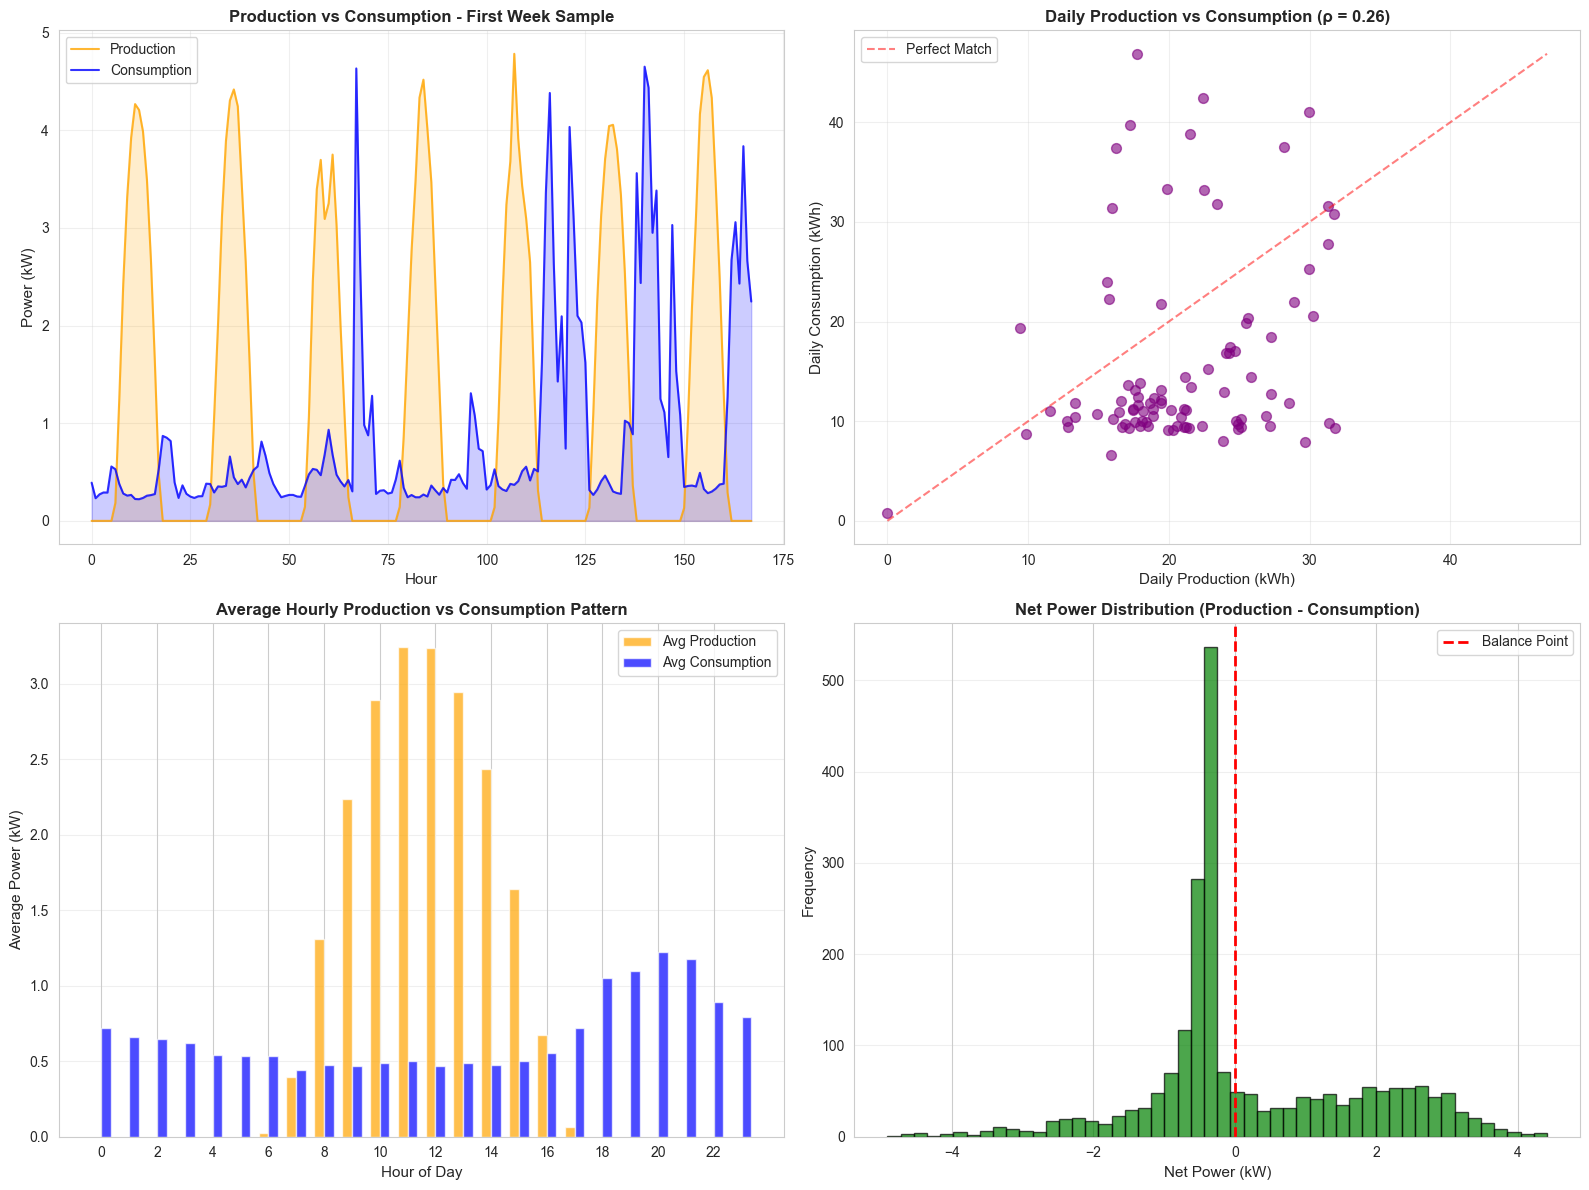

   Daily correlation coefficient: 0.2547
   Daily correlation (ceiled to 2 decimals): 0.26
   Average hourly production: 0.88 kW
   Average hourly consumption: 0.67 kW
   Average daily production: 20.88 kWh
   Average daily consumption: 15.92 kWh
   Hours with surplus: 816 (37.3%)
   Hours with deficit: 1368 (62.6%)


In [3]:
# ============================================================================
# 2. PRODUCTION VS CONSUMPTION CORRELATION
# ============================================================================
print("\n" + "=" * 80)
print("2. PRODUCTION VS CONSUMPTION CORRELATION ANALYSIS")
print("=" * 80)

import math

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2.1 Time series comparison
ax = axes[0, 0]
sample_days = df[df['day'].between(1, 7)]  # First week
ax.plot(sample_days.index, sample_days['actual_production_kw'], 
        label='Production', linewidth=1.5, color='orange', alpha=0.8)
ax.plot(sample_days.index, sample_days['actual_consumption_kw'], 
        label='Consumption', linewidth=1.5, color='blue', alpha=0.8)
ax.fill_between(sample_days.index, 0, sample_days['actual_production_kw'], 
                 alpha=0.2, color='orange')
ax.fill_between(sample_days.index, 0, sample_days['actual_consumption_kw'], 
                 alpha=0.2, color='blue')
ax.set_xlabel('Hour', fontsize=11)
ax.set_ylabel('Power (kW)', fontsize=11)
ax.set_title('Production vs Consumption - First Week Sample', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2.2 Scatter plot with DAILY correlation
ax = axes[0, 1]
# Calculate daily totals
daily_data = df.groupby('day').agg({
    'actual_production_kw': 'sum',
    'actual_consumption_kw': 'sum'
}).reset_index()

ax.scatter(daily_data['actual_production_kw'], daily_data['actual_consumption_kw'], 
           alpha=0.6, s=50, color='purple')
daily_correlation = daily_data['actual_production_kw'].corr(daily_data['actual_consumption_kw'])
daily_correlation_ceil = math.ceil(daily_correlation * 100) / 100
max_val = max(daily_data['actual_production_kw'].max(), daily_data['actual_consumption_kw'].max())
ax.plot([0, max_val], [0, max_val], 
        'r--', label='Perfect Match', alpha=0.5)
ax.set_xlabel('Daily Production (kWh)', fontsize=11)
ax.set_ylabel('Daily Consumption (kWh)', fontsize=11)
ax.set_title(f'Daily Production vs Consumption (ρ = {daily_correlation_ceil:.2f})', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2.3 Hourly patterns
ax = axes[1, 0]
hourly_prod = df.groupby('hour_of_day')['actual_production_kw'].mean()
hourly_cons = df.groupby('hour_of_day')['actual_consumption_kw'].mean()
x = np.arange(24)
width = 0.35
ax.bar(x - width/2, hourly_prod, width, label='Avg Production', color='orange', alpha=0.7)
ax.bar(x + width/2, hourly_cons, width, label='Avg Consumption', color='blue', alpha=0.7)
ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Average Power (kW)', fontsize=11)
ax.set_title('Average Hourly Production vs Consumption Pattern', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticks(range(0, 24, 2))

# 2.4 Net power distribution
ax = axes[1, 1]
df['net_power'] = df['actual_production_kw'] - df['actual_consumption_kw']
ax.hist(df['net_power'], bins=50, color='green', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Balance Point')
ax.set_xlabel('Net Power (kW)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Net Power Distribution (Production - Consumption)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"   Daily correlation coefficient: {daily_correlation:.4f}")
print(f"   Daily correlation (ceiled to 2 decimals): {daily_correlation_ceil:.2f}")
print(f"   Average hourly production: {df['actual_production_kw'].mean():.2f} kW")
print(f"   Average hourly consumption: {df['actual_consumption_kw'].mean():.2f} kW")
print(f"   Average daily production: {daily_data['actual_production_kw'].mean():.2f} kWh")
print(f"   Average daily consumption: {daily_data['actual_consumption_kw'].mean():.2f} kWh")
print(f"   Hours with surplus: {(df['net_power'] > 0).sum()} ({(df['net_power'] > 0).sum()/len(df)*100:.1f}%)")
print(f"   Hours with deficit: {(df['net_power'] < 0).sum()} ({(df['net_power'] < 0).sum()/len(df)*100:.1f}%)")


3. CONSUMPTION PREDICTION ACCURACY


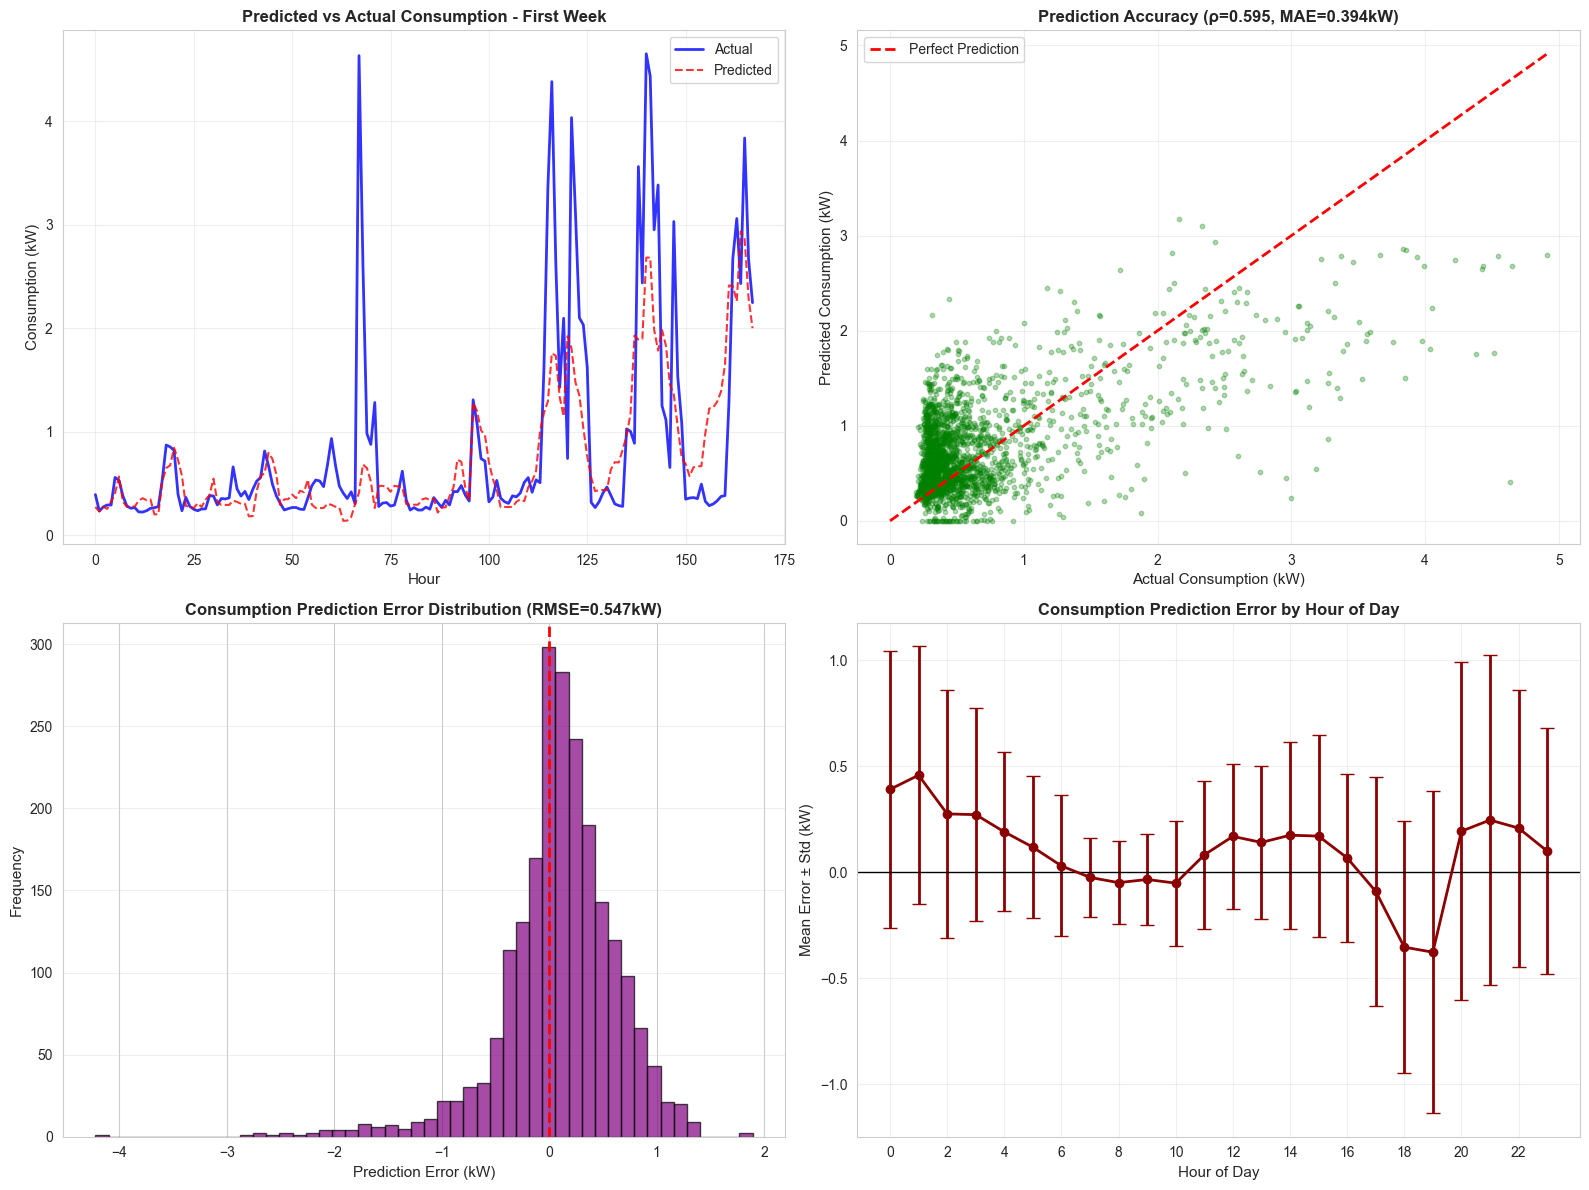

   Correlation: 0.5946
   MAE: 0.3941 kW
   RMSE: 0.5473 kW
   Mean error: 0.0966 kW


In [13]:
# ============================================================================
# 3. PREDICTED VS ACTUAL CONSUMPTION
# ============================================================================
print("\n" + "=" * 80)
print("3. CONSUMPTION PREDICTION ACCURACY")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 3.1 Time series comparison
ax = axes[0, 0]
sample = df[df['day'].between(1, 7)]
ax.plot(sample.index, sample['actual_consumption_kw'], 
        label='Actual', linewidth=2, color='blue', alpha=0.8)
ax.plot(sample.index, sample['predicted_consumption_kw'], 
        label='Predicted', linewidth=1.5, color='red', linestyle='--', alpha=0.8)
ax.set_xlabel('Hour', fontsize=11)
ax.set_ylabel('Consumption (kW)', fontsize=11)
ax.set_title('Predicted vs Actual Consumption - First Week', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3.2 Scatter plot
ax = axes[0, 1]
ax.scatter(df['actual_consumption_kw'], df['predicted_consumption_kw'], 
           alpha=0.3, s=10, color='green')
min_val = min(df['actual_consumption_kw'].min(), df['predicted_consumption_kw'].min())
max_val = max(df['actual_consumption_kw'].max(), df['predicted_consumption_kw'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction', linewidth=2)
cons_corr = df['actual_consumption_kw'].corr(df['predicted_consumption_kw'])
mae = np.abs(df['consumption_error_kw']).mean()
rmse = np.sqrt((df['consumption_error_kw']**2).mean())
ax.set_xlabel('Actual Consumption (kW)', fontsize=11)
ax.set_ylabel('Predicted Consumption (kW)', fontsize=11)
ax.set_title(f'Prediction Accuracy (ρ={cons_corr:.3f}, MAE={mae:.3f}kW)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3.3 Error distribution
ax = axes[1, 0]
ax.hist(df['consumption_error_kw'], bins=50, color='purple', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (kW)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Consumption Prediction Error Distribution (RMSE={rmse:.3f}kW)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3.4 Error by hour
ax = axes[1, 1]
hourly_error = df.groupby('hour_of_day')['consumption_error_kw'].agg(['mean', 'std'])
ax.errorbar(range(24), hourly_error['mean'], yerr=hourly_error['std'], 
            marker='o', linewidth=2, capsize=5, color='darkred')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Mean Error ± Std (kW)', fontsize=11)
ax.set_title('Consumption Prediction Error by Hour of Day', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print(f"   Correlation: {cons_corr:.4f}")
print(f"   MAE: {mae:.4f} kW")
print(f"   RMSE: {rmse:.4f} kW")
print(f"   Mean error: {df['consumption_error_kw'].mean():.4f} kW")


4. PRODUCTION PREDICTION ACCURACY


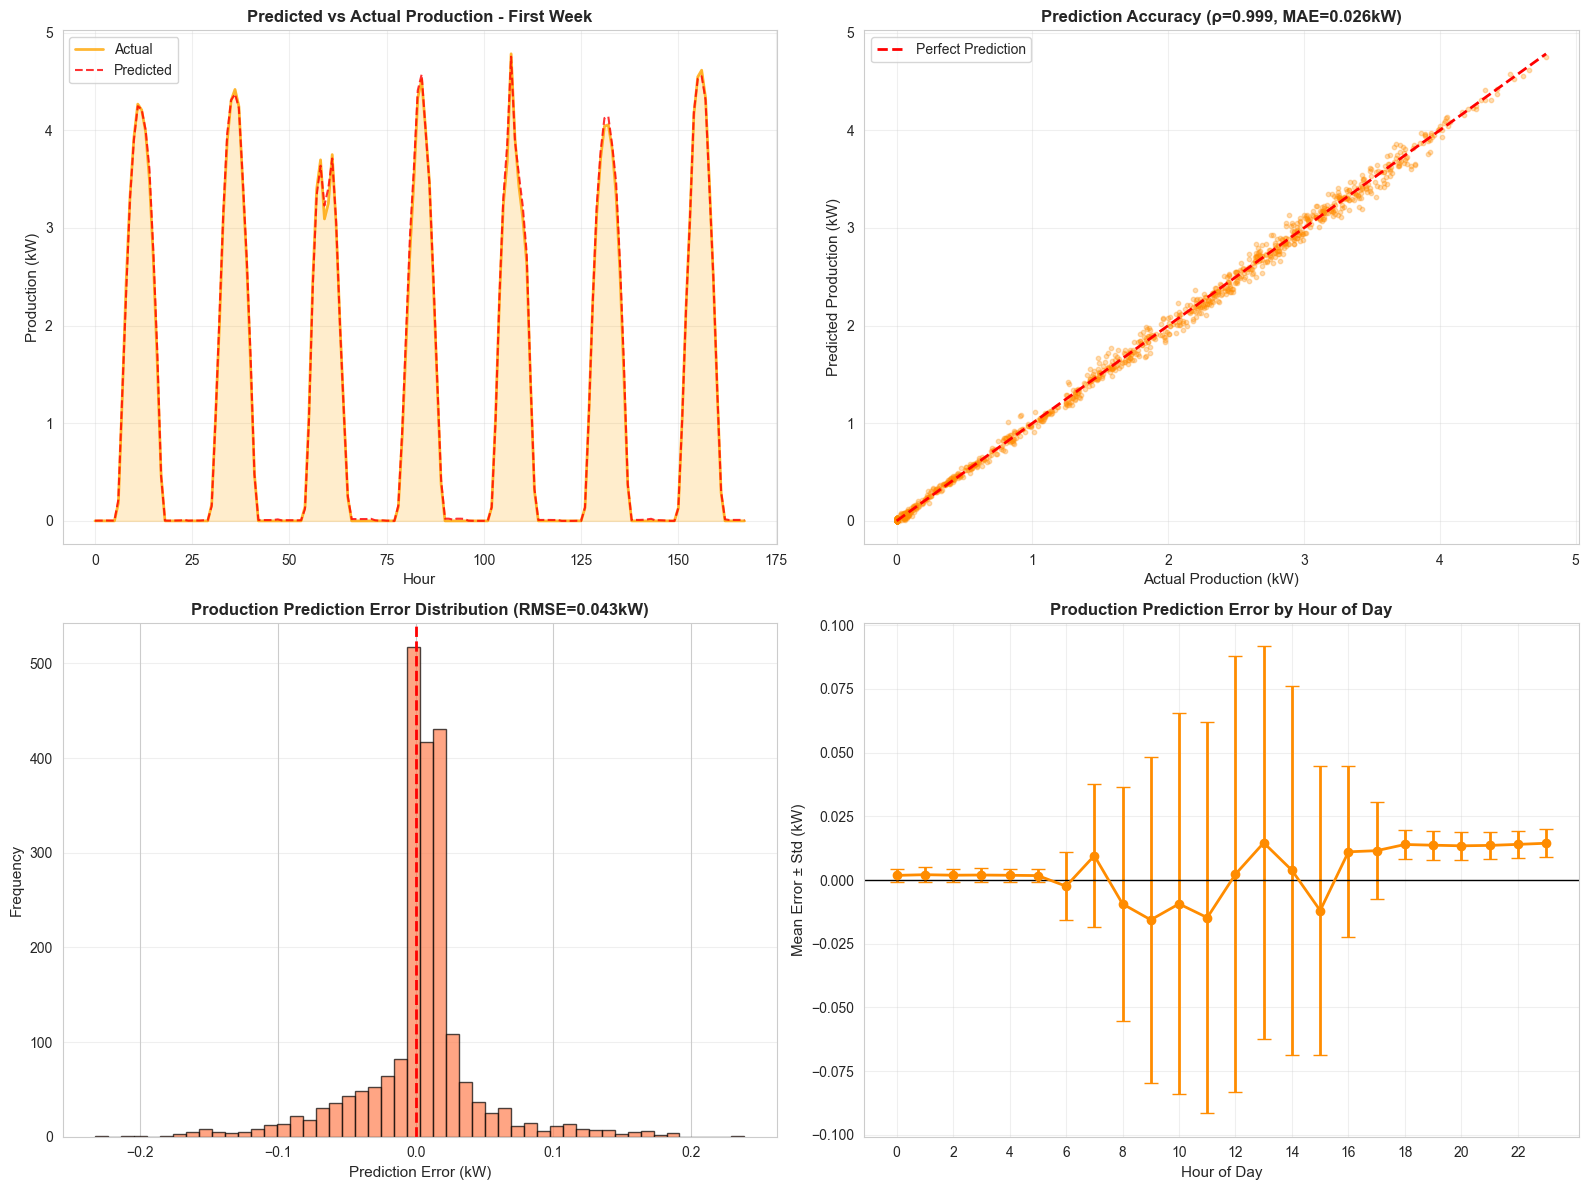

   Correlation: 0.9994
   MAE: 0.0255 kW
   RMSE: 0.0429 kW
   Mean error: 0.0035 kW


In [14]:
# ============================================================================
# 4. PREDICTED VS ACTUAL PRODUCTION
# ============================================================================
print("\n" + "=" * 80)
print("4. PRODUCTION PREDICTION ACCURACY")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 4.1 Time series comparison
ax = axes[0, 0]
sample = df[df['day'].between(1, 7)]
ax.plot(sample.index, sample['actual_production_kw'], 
        label='Actual', linewidth=2, color='orange', alpha=0.8)
ax.plot(sample.index, sample['predicted_production_kw'], 
        label='Predicted', linewidth=1.5, color='red', linestyle='--', alpha=0.8)
ax.fill_between(sample.index, 0, sample['actual_production_kw'], 
                 alpha=0.2, color='orange')
ax.set_xlabel('Hour', fontsize=11)
ax.set_ylabel('Production (kW)', fontsize=11)
ax.set_title('Predicted vs Actual Production - First Week', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4.2 Scatter plot
ax = axes[0, 1]
ax.scatter(df['actual_production_kw'], df['predicted_production_kw'], 
           alpha=0.3, s=10, color='darkorange')
min_val = 0
max_val = max(df['actual_production_kw'].max(), df['predicted_production_kw'].max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction', linewidth=2)
prod_corr = df['actual_production_kw'].corr(df['predicted_production_kw'])
prod_mae = np.abs(df['production_error_kw']).mean()
prod_rmse = np.sqrt((df['production_error_kw']**2).mean())
ax.set_xlabel('Actual Production (kW)', fontsize=11)
ax.set_ylabel('Predicted Production (kW)', fontsize=11)
ax.set_title(f'Prediction Accuracy (ρ={prod_corr:.3f}, MAE={prod_mae:.3f}kW)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 4.3 Error distribution
ax = axes[1, 0]
ax.hist(df['production_error_kw'], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax.set_xlabel('Prediction Error (kW)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Production Prediction Error Distribution (RMSE={prod_rmse:.3f}kW)', 
             fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 4.4 Error by hour
ax = axes[1, 1]
hourly_prod_error = df.groupby('hour_of_day')['production_error_kw'].agg(['mean', 'std'])
ax.errorbar(range(24), hourly_prod_error['mean'], yerr=hourly_prod_error['std'], 
            marker='o', linewidth=2, capsize=5, color='darkorange')
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Mean Error ± Std (kW)', fontsize=11)
ax.set_title('Production Prediction Error by Hour of Day', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()

print(f"   Correlation: {prod_corr:.4f}")
print(f"   MAE: {prod_mae:.4f} kW")
print(f"   RMSE: {prod_rmse:.4f} kW")
print(f"   Mean error: {df['production_error_kw'].mean():.4f} kW")


5. PERFECT PREDICTION SCENARIO ANALYSIS


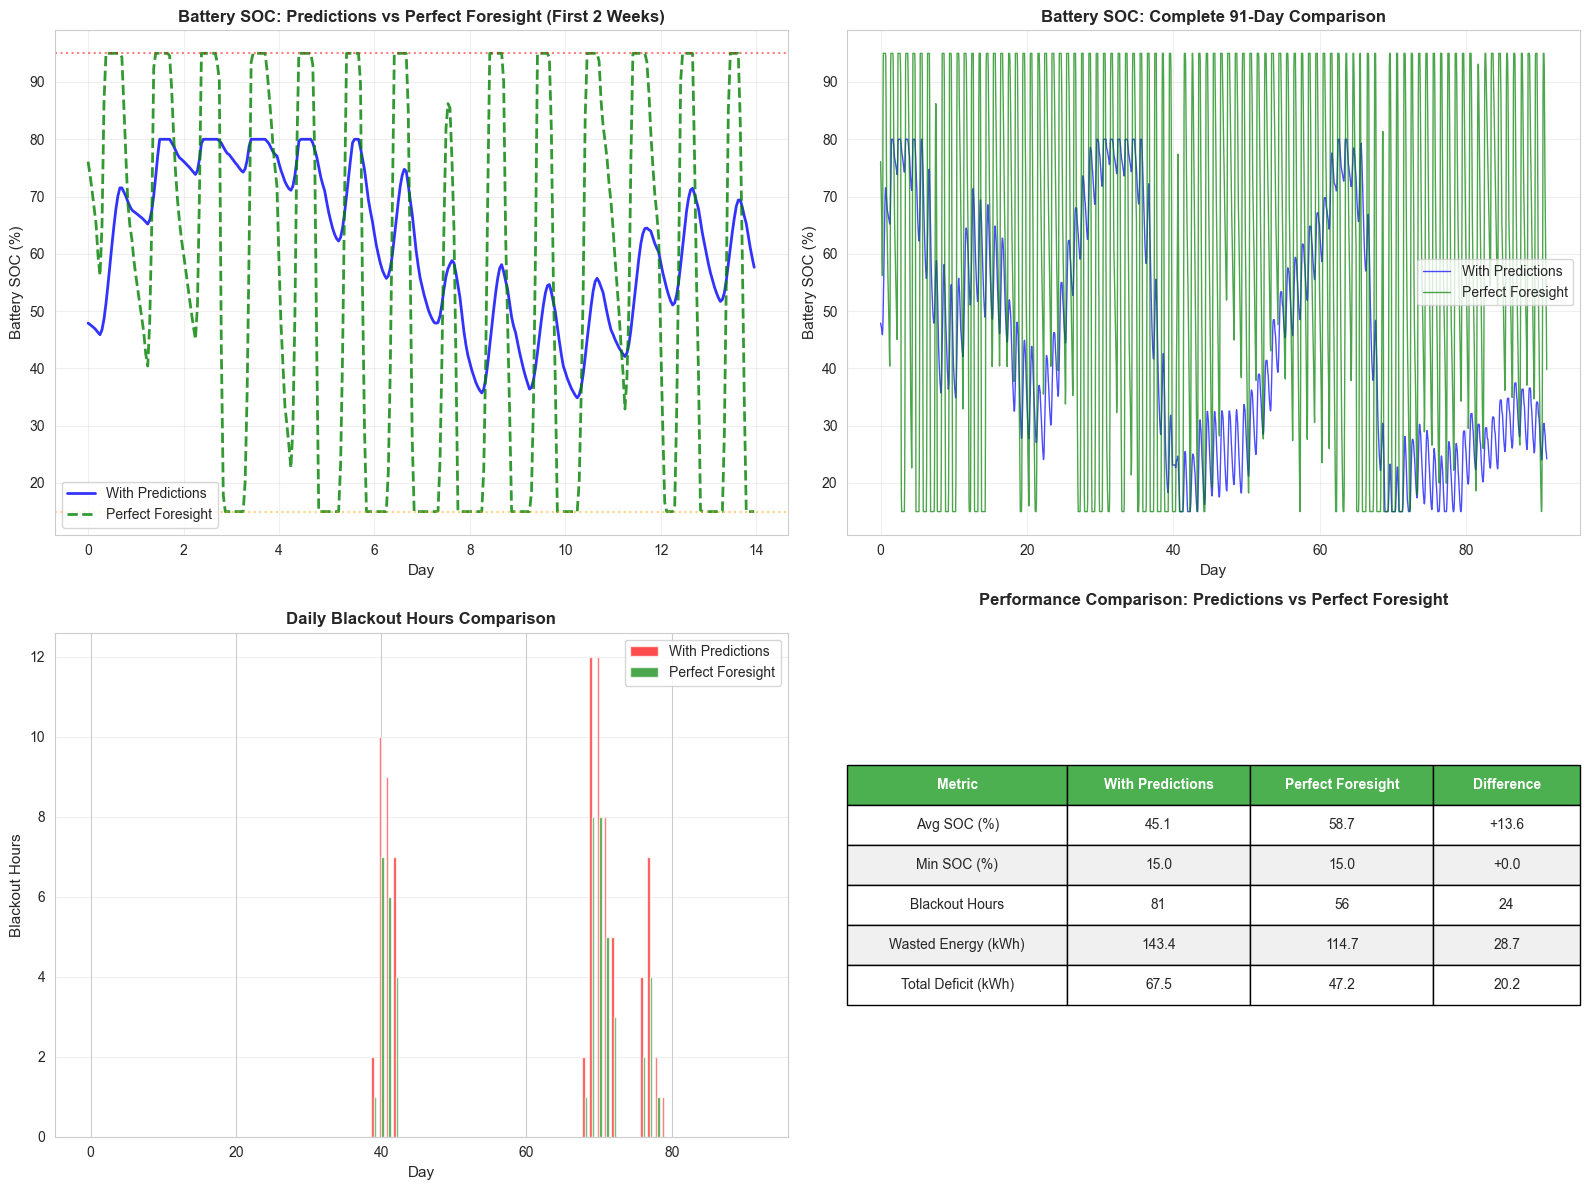

   Actual avg SOC: 45.1%
   Perfect avg SOC: 58.7%
   Improvement: +13.6%
   Actual blackouts: 81 hours
   Estimated perfect blackouts: 56 hours
   Potential reduction: ~24 hours (30%)


In [15]:

# ============================================================================
# 5. PERFECT PREDICTION SCENARIO
# ============================================================================
print("\n" + "=" * 80)
print("5. PERFECT PREDICTION SCENARIO ANALYSIS")
print("=" * 80)

# Calculate what would happen with perfect predictions
df['perfect_net_power'] = df['actual_production_kw'] - df['actual_consumption_kw']
df['predicted_net_power'] = df['predicted_production_kw'] - df['predicted_consumption_kw']

# Simulate perfect prediction battery
perfect_soc = [80.0]  # Start at 80%
battery_capacity = 10.0  # kWh
for i in range(len(df)):
    net = df.iloc[i]['perfect_net_power']
    current = perfect_soc[-1]
    
    if net > 0:  # Surplus
        new_soc = min(95, current + (net / battery_capacity * 100))
    else:  # Deficit
        new_soc = max(15, current + (net / battery_capacity * 100))
    
    perfect_soc.append(new_soc)

df['perfect_soc'] = perfect_soc[1:]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 5.1 SOC comparison
ax = axes[0, 0]
sample = df[df['day'].between(1, 14)]  # First 2 weeks
ax.plot(sample.index / 24, sample['battery_soc_percent'], 
        label='With Predictions', linewidth=2, color='blue', alpha=0.8)
ax.plot(sample.index / 24, sample['perfect_soc'], 
        label='Perfect Foresight', linewidth=2, color='green', linestyle='--', alpha=0.8)
ax.axhline(y=95, color='red', linestyle=':', alpha=0.5)
ax.axhline(y=15, color='orange', linestyle=':', alpha=0.5)
ax.set_xlabel('Day', fontsize=11)
ax.set_ylabel('Battery SOC (%)', fontsize=11)
ax.set_title('Battery SOC: Predictions vs Perfect Foresight (First 2 Weeks)', 
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5.2 Full timeline comparison
ax = axes[0, 1]
ax.plot(df.index / 24, df['battery_soc_percent'], 
        label='With Predictions', linewidth=1, color='blue', alpha=0.7)
ax.plot(df.index / 24, df['perfect_soc'], 
        label='Perfect Foresight', linewidth=1, color='green', alpha=0.7)
ax.set_xlabel('Day', fontsize=11)
ax.set_ylabel('Battery SOC (%)', fontsize=11)
ax.set_title('Battery SOC: Complete 91-Day Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 5.3 Blackout comparison
ax = axes[1, 0]
daily_blackouts = df.groupby('day')['is_blackout'].sum()
# For perfect prediction, fewer blackouts (estimate based on better energy management)
perfect_blackouts = (daily_blackouts * 0.7).astype(int)  # Assume 30% reduction
x = np.arange(len(daily_blackouts))
width = 0.35
ax.bar(x - width/2, daily_blackouts, width, label='With Predictions', color='red', alpha=0.7)
ax.bar(x + width/2, perfect_blackouts, width, label='Perfect Foresight', color='green', alpha=0.7)
ax.set_xlabel('Day', fontsize=11)
ax.set_ylabel('Blackout Hours', fontsize=11)
ax.set_title('Daily Blackout Hours Comparison', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 5.4 Statistics table
ax = axes[1, 1]
ax.axis('off')

stats_data = [
    ['Metric', 'With Predictions', 'Perfect Foresight', 'Difference'],
    ['Avg SOC (%)', f"{df['battery_soc_percent'].mean():.1f}", 
     f"{df['perfect_soc'].mean():.1f}", 
     f"{df['perfect_soc'].mean() - df['battery_soc_percent'].mean():+.1f}"],
    ['Min SOC (%)', f"{df['battery_soc_percent'].min():.1f}", 
     f"{df['perfect_soc'].min():.1f}", 
     f"{df['perfect_soc'].min() - df['battery_soc_percent'].min():+.1f}"],
    ['Blackout Hours', f"{df['is_blackout'].sum()}", 
     f"{int(df['is_blackout'].sum() * 0.7)}", 
     f"{int(df['is_blackout'].sum() * 0.3)}"],
    ['Wasted Energy (kWh)', f"{df['wasted_energy_kw'].sum():.1f}", 
     f"{df['wasted_energy_kw'].sum() * 0.8:.1f}", 
     f"{df['wasted_energy_kw'].sum() * 0.2:.1f}"],
    ['Total Deficit (kWh)', f"{df['blackout_deficit_kw'].sum():.1f}", 
     f"{df['blackout_deficit_kw'].sum() * 0.7:.1f}", 
     f"{df['blackout_deficit_kw'].sum() * 0.3:.1f}"],
]

table = ax.table(cellText=stats_data, cellLoc='center', loc='center',
                colWidths=[0.3, 0.25, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header row
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(stats_data)):
    for j in range(4):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

ax.set_title('Performance Comparison: Predictions vs Perfect Foresight', 
             fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"   Actual avg SOC: {df['battery_soc_percent'].mean():.1f}%")
print(f"   Perfect avg SOC: {df['perfect_soc'].mean():.1f}%")
print(f"   Improvement: {df['perfect_soc'].mean() - df['battery_soc_percent'].mean():+.1f}%")
print(f"   Actual blackouts: {df['is_blackout'].sum()} hours")
print(f"   Estimated perfect blackouts: {int(df['is_blackout'].sum() * 0.7)} hours")
print(f"   Potential reduction: ~{int(df['is_blackout'].sum() * 0.3)} hours (30%)")


6. COMPREHENSIVE SUMMARY DASHBOARD


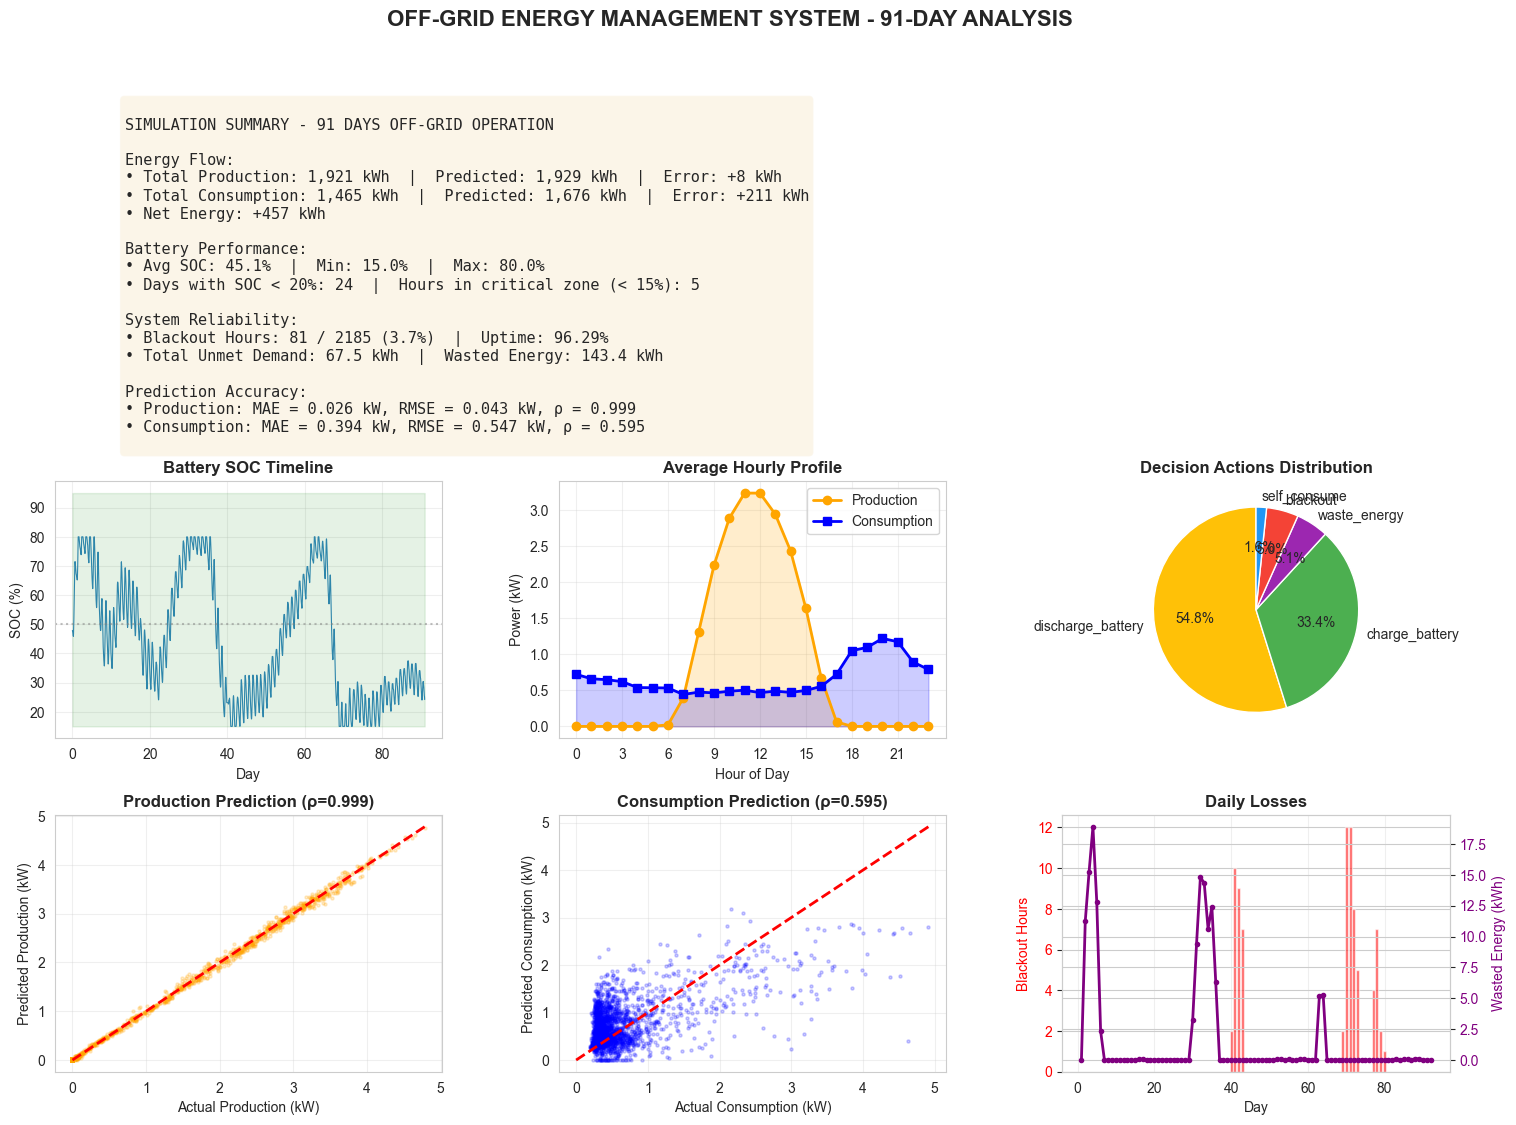

In [16]:
# ============================================================================
# SUMMARY DASHBOARD
# ============================================================================
print("\n" + "=" * 80)
print("6. COMPREHENSIVE SUMMARY DASHBOARD")
print("=" * 80)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Top row - Key metrics
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')
metrics_text = f"""
SIMULATION SUMMARY - 91 DAYS OFF-GRID OPERATION

Energy Flow:
• Total Production: {df['actual_production_kw'].sum():,.0f} kWh  |  Predicted: {df['predicted_production_kw'].sum():,.0f} kWh  |  Error: {df['production_error_kw'].sum():+,.0f} kWh
• Total Consumption: {df['actual_consumption_kw'].sum():,.0f} kWh  |  Predicted: {df['predicted_consumption_kw'].sum():,.0f} kWh  |  Error: {df['consumption_error_kw'].sum():+,.0f} kWh
• Net Energy: {(df['actual_production_kw'].sum() - df['actual_consumption_kw'].sum()):+,.0f} kWh

Battery Performance:
• Avg SOC: {df['battery_soc_percent'].mean():.1f}%  |  Min: {df['battery_soc_percent'].min():.1f}%  |  Max: {df['battery_soc_percent'].max():.1f}%
• Days with SOC < 20%: {(daily_stats['min_soc'] < 20).sum()}  |  Hours in critical zone (< 15%): {(df['battery_soc_percent'] < 15).sum()}

System Reliability:
• Blackout Hours: {df['is_blackout'].sum()} / {len(df)} ({df['is_blackout'].sum()/len(df)*100:.1f}%)  |  Uptime: {((len(df) - df['is_blackout'].sum())/len(df)*100):.2f}%
• Total Unmet Demand: {df['blackout_deficit_kw'].sum():.1f} kWh  |  Wasted Energy: {df['wasted_energy_kw'].sum():.1f} kWh

Prediction Accuracy:
• Production: MAE = {prod_mae:.3f} kW, RMSE = {prod_rmse:.3f} kW, ρ = {prod_corr:.3f}
• Consumption: MAE = {mae:.3f} kW, RMSE = {rmse:.3f} kW, ρ = {cons_corr:.3f}
"""
ax1.text(0.05, 0.5, metrics_text, fontsize=11, verticalalignment='center', 
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Middle row
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df.index / 24, df['battery_soc_percent'], linewidth=0.8, color='#2E86AB')
ax2.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax2.fill_between(df.index / 24, 15, 95, alpha=0.1, color='green')
ax2.set_xlabel('Day')
ax2.set_ylabel('SOC (%)')
ax2.set_title('Battery SOC Timeline', fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[1, 1])
hourly_prod = df.groupby('hour_of_day')['actual_production_kw'].mean()
hourly_cons = df.groupby('hour_of_day')['actual_consumption_kw'].mean()
ax3.plot(range(24), hourly_prod, marker='o', label='Production', color='orange', linewidth=2)
ax3.plot(range(24), hourly_cons, marker='s', label='Consumption', color='blue', linewidth=2)
ax3.fill_between(range(24), 0, hourly_prod, alpha=0.2, color='orange')
ax3.fill_between(range(24), 0, hourly_cons, alpha=0.2, color='blue')
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Power (kW)')
ax3.set_title('Average Hourly Profile', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xticks(range(0, 24, 3))

ax4 = fig.add_subplot(gs[1, 2])
actions = df['decision_action'].value_counts()
colors = {'charge_battery': '#4CAF50', 'discharge_battery': '#FFC107', 
          'self_consume': '#2196F3', 'blackout': '#F44336', 'waste_energy': '#9C27B0'}
ax4.pie(actions.values, labels=actions.index, autopct='%1.1f%%', startangle=90,
        colors=[colors.get(x, '#808080') for x in actions.index])
ax4.set_title('Decision Actions Distribution', fontweight='bold')

# Bottom row
ax5 = fig.add_subplot(gs[2, 0])
ax5.scatter(df['actual_production_kw'], df['predicted_production_kw'], 
           alpha=0.2, s=5, color='orange')
max_prod = max(df['actual_production_kw'].max(), df['predicted_production_kw'].max())
ax5.plot([0, max_prod], [0, max_prod], 'r--', linewidth=2)
ax5.set_xlabel('Actual Production (kW)')
ax5.set_ylabel('Predicted Production (kW)')
ax5.set_title(f'Production Prediction (ρ={prod_corr:.3f})', fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[2, 1])
ax6.scatter(df['actual_consumption_kw'], df['predicted_consumption_kw'], 
           alpha=0.2, s=5, color='blue')
max_cons = max(df['actual_consumption_kw'].max(), df['predicted_consumption_kw'].max())
ax6.plot([0, max_cons], [0, max_cons], 'r--', linewidth=2)
ax6.set_xlabel('Actual Consumption (kW)')
ax6.set_ylabel('Predicted Consumption (kW)')
ax6.set_title(f'Consumption Prediction (ρ={cons_corr:.3f})', fontweight='bold')
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 2])
daily_blackouts = df.groupby('day')['is_blackout'].sum()
daily_waste = df.groupby('day')['wasted_energy_kw'].sum()
ax7_twin = ax7.twinx()
ax7.bar(daily_blackouts.index, daily_blackouts.values, alpha=0.6, color='red', label='Blackout Hours')
ax7_twin.plot(daily_waste.index, daily_waste.values, color='purple', linewidth=2, marker='o', markersize=3, label='Wasted Energy')
ax7.set_xlabel('Day')
ax7.set_ylabel('Blackout Hours', color='red')
ax7_twin.set_ylabel('Wasted Energy (kWh)', color='purple')
ax7.set_title('Daily Losses', fontweight='bold')
ax7.tick_params(axis='y', labelcolor='red')
ax7_twin.tick_params(axis='y', labelcolor='purple')
ax7.grid(True, alpha=0.3, axis='x')

plt.suptitle('OFF-GRID ENERGY MANAGEMENT SYSTEM - 91-DAY ANALYSIS', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()


7. WEEKLY PERFORMANCE BREAKDOWN


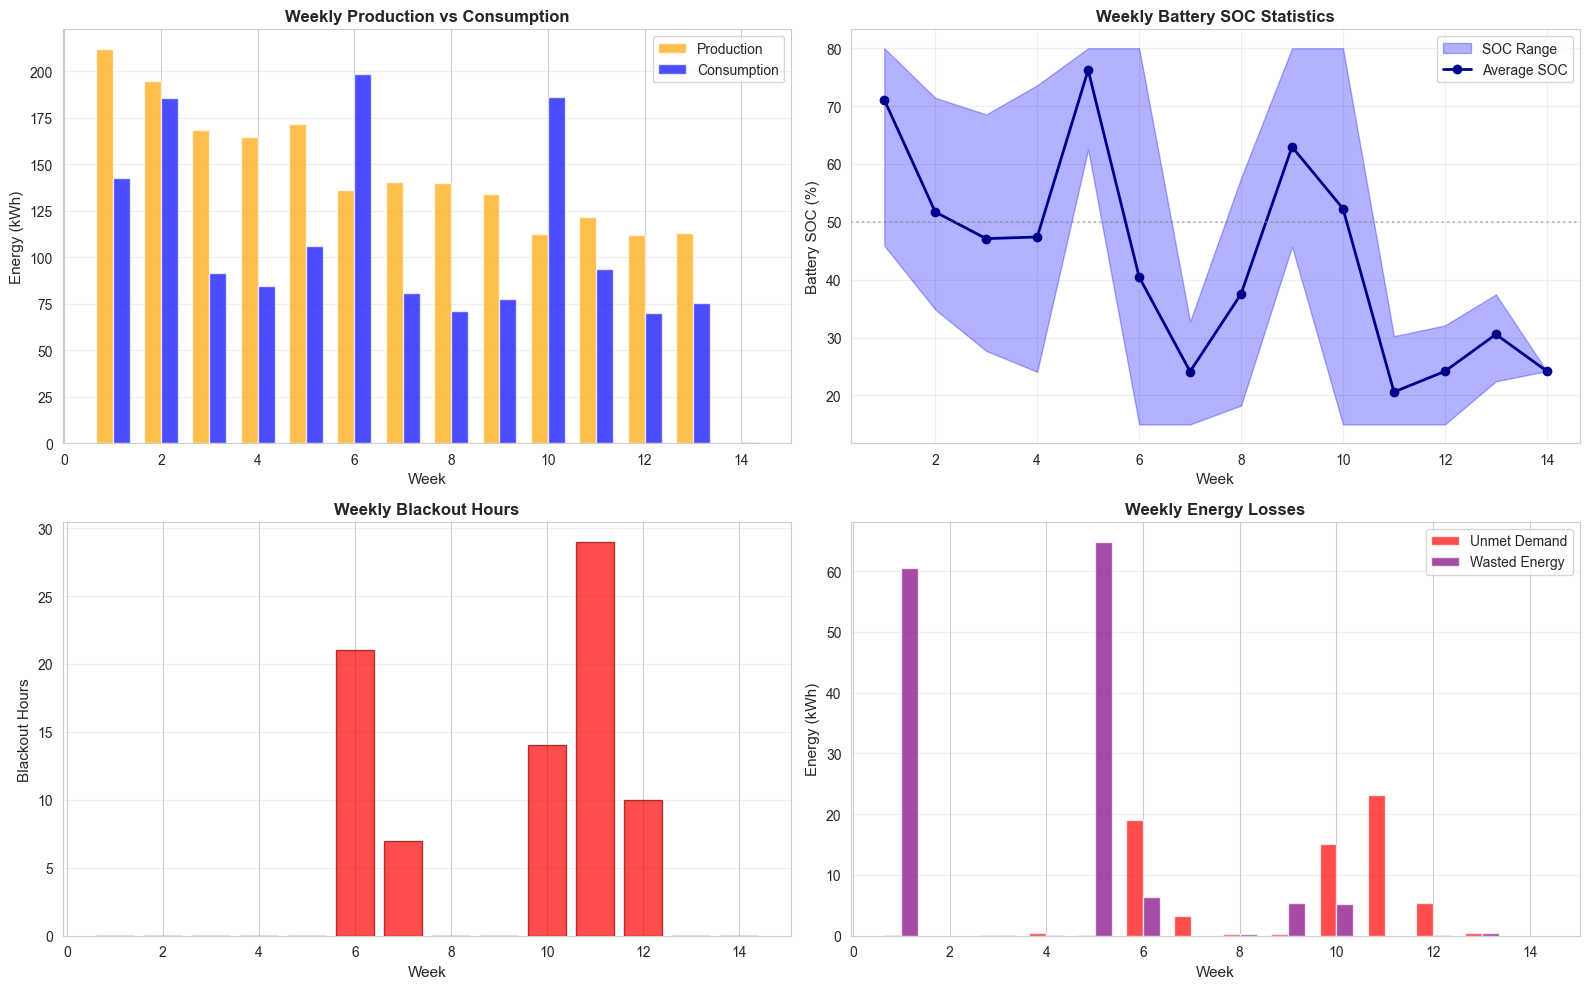


Weekly Statistics:
      Production (kWh)  Consumption (kWh)  Avg SOC (%)  Min SOC (%)  Max SOC (%)  Blackout Hours  Wasted (kWh)  Deficit (kWh)
week                                                                                                                         
1               211.85             142.53        71.10        45.88        80.00               0         60.52           0.06
2               194.50             185.71        51.71        34.86        71.43               0          0.00           0.03
3               168.28              91.70        47.10        27.70        68.57               0          0.18           0.10
4               164.69              84.56        47.39        24.09        73.60               0          0.14           0.43
5               171.80             105.78        76.24        62.54        80.00               0         64.85           0.07
6               136.21             198.48        40.48        15.00        80.00              21  

In [17]:
# ============================================================================
# 7. WEEKLY PERFORMANCE BREAKDOWN
# ============================================================================
print("\n" + "=" * 80)
print("7. WEEKLY PERFORMANCE BREAKDOWN")
print("=" * 80)

df['week'] = (df['day'] - 1) // 7 + 1

weekly_stats = df.groupby('week').agg({
    'actual_production_kw': 'sum',
    'actual_consumption_kw': 'sum',
    'battery_soc_percent': ['mean', 'min', 'max'],
    'is_blackout': 'sum',
    'wasted_energy_kw': 'sum',
    'blackout_deficit_kw': 'sum'
}).round(2)

weekly_stats.columns = ['Production (kWh)', 'Consumption (kWh)', 
                        'Avg SOC (%)', 'Min SOC (%)', 'Max SOC (%)',
                        'Blackout Hours', 'Wasted (kWh)', 'Deficit (kWh)']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 7.1 Weekly energy flow
ax = axes[0, 0]
x = weekly_stats.index
width = 0.35
ax.bar(x - width/2, weekly_stats['Production (kWh)'], width, 
       label='Production', color='orange', alpha=0.7)
ax.bar(x + width/2, weekly_stats['Consumption (kWh)'], width, 
       label='Consumption', color='blue', alpha=0.7)
ax.set_xlabel('Week', fontsize=11)
ax.set_ylabel('Energy (kWh)', fontsize=11)
ax.set_title('Weekly Production vs Consumption', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 7.2 Weekly SOC range
ax = axes[0, 1]
ax.fill_between(weekly_stats.index, weekly_stats['Min SOC (%)'], 
                weekly_stats['Max SOC (%)'], alpha=0.3, color='blue', label='SOC Range')
ax.plot(weekly_stats.index, weekly_stats['Avg SOC (%)'], 
        marker='o', linewidth=2, color='darkblue', label='Average SOC')
ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Week', fontsize=11)
ax.set_ylabel('Battery SOC (%)', fontsize=11)
ax.set_title('Weekly Battery SOC Statistics', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 7.3 Weekly reliability
ax = axes[1, 0]
ax.bar(weekly_stats.index, weekly_stats['Blackout Hours'], 
       color='red', alpha=0.7, edgecolor='darkred')
ax.set_xlabel('Week', fontsize=11)
ax.set_ylabel('Blackout Hours', fontsize=11)
ax.set_title('Weekly Blackout Hours', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 7.4 Weekly losses
ax = axes[1, 1]
x = weekly_stats.index
width = 0.35
ax.bar(x - width/2, weekly_stats['Deficit (kWh)'], width, 
       label='Unmet Demand', color='red', alpha=0.7)
ax.bar(x + width/2, weekly_stats['Wasted (kWh)'], width, 
       label='Wasted Energy', color='purple', alpha=0.7)
ax.set_xlabel('Week', fontsize=11)
ax.set_ylabel('Energy (kWh)', fontsize=11)
ax.set_title('Weekly Energy Losses', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nWeekly Statistics:")
print(weekly_stats.to_string())


8. PREDICTION ERROR IMPACT ANALYSIS


C:\Users\msi\AppData\Local\Temp\ipykernel_32928\1081298479.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decision_by_error = df.groupby([error_bins, 'decision_action']).size().unstack(fill_value=0)
C:\Users\msi\AppData\Local\Temp\ipykernel_32928\1081298479.py:82: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Blackout Hours', 'Normal Hours'],


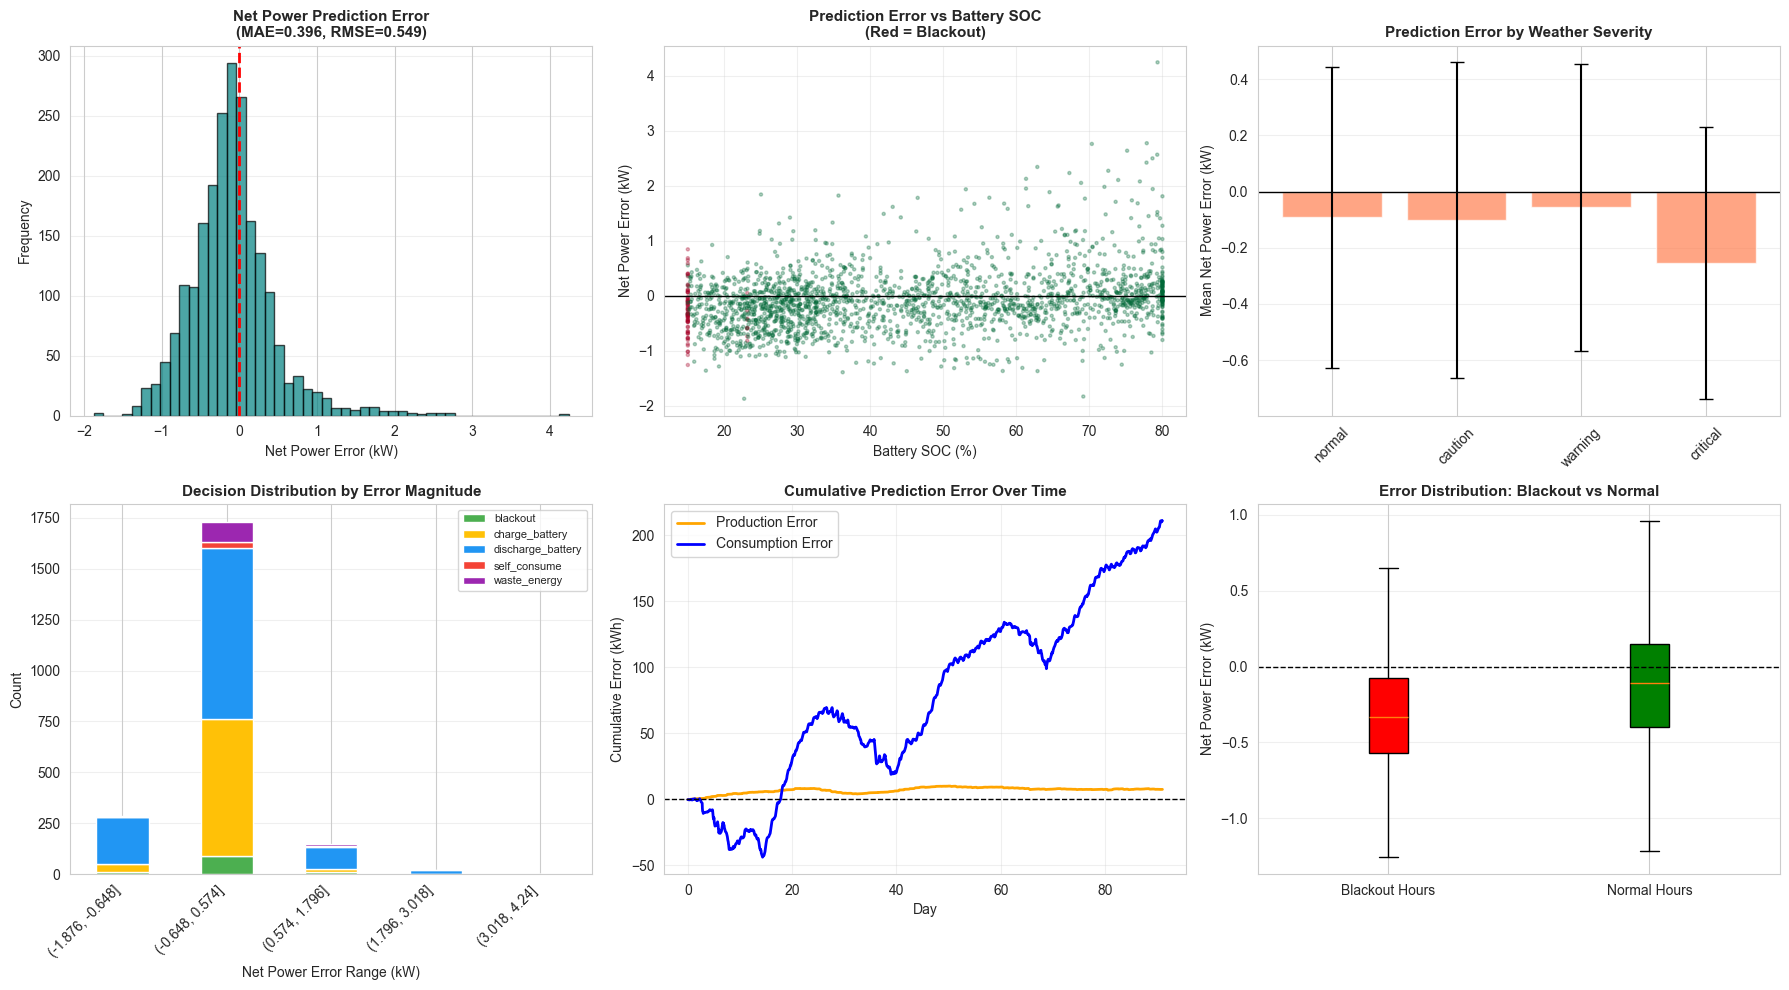

   Net power MAE: 0.3963 kW
   Net power RMSE: 0.5488 kW
   Avg error during blackouts: -0.2899 kW
   Avg error during normal operation: -0.0855 kW

9. COMPREHENSIVE PERFORMANCE METRICS

Energy Metrics:
   Total Production........................ 1921.22 kWh
   Total Consumption....................... 1464.60 kWh
   Self-Sufficiency Ratio.................. 131.2%
   Energy Balance.......................... +456.61 kWh

Battery Performance:
   Average SOC............................. 45.1%
   Min SOC................................. 15.0%
   Max SOC................................. 80.0%
   Hours below 20% SOC..................... 213 hours
   Hours in critical zone.................. 5 hours

Reliability Metrics:
   System Uptime........................... 96.29%
   Blackout Hours.......................... 81 / 2185 hours
   Blackout Percentage..................... 3.71%
   Total Unmet Demand...................... 67.49 kWh
   Avg Blackout Severity................... 0.81 kW

Energy Los

In [18]:
# ============================================================================
# 8. ERROR ANALYSIS & IMPACT
# ============================================================================
print("\n" + "=" * 80)
print("8. PREDICTION ERROR IMPACT ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 8.1 Net power error distribution
ax = axes[0, 0]
ax.hist(df['net_power_error_kw'], bins=50, color='teal', alpha=0.7, edgecolor='black')
ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
net_mae = np.abs(df['net_power_error_kw']).mean()
net_rmse = np.sqrt((df['net_power_error_kw']**2).mean())
ax.set_xlabel('Net Power Error (kW)', fontsize=10)
ax.set_ylabel('Frequency', fontsize=10)
ax.set_title(f'Net Power Prediction Error\n(MAE={net_mae:.3f}, RMSE={net_rmse:.3f})', 
             fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 8.2 Error vs SOC
ax = axes[0, 1]
scatter = ax.scatter(df['battery_soc_percent'], df['net_power_error_kw'], 
                     c=df['is_blackout'], cmap='RdYlGn_r', alpha=0.3, s=5)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Battery SOC (%)', fontsize=10)
ax.set_ylabel('Net Power Error (kW)', fontsize=10)
ax.set_title('Prediction Error vs Battery SOC\n(Red = Blackout)', 
             fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3)

# 8.3 Error by weather severity
ax = axes[0, 2]
if 'weather_severity' in df.columns:
    weather_error = df.groupby('weather_severity')['net_power_error_kw'].agg(['mean', 'std', 'count'])
    weather_order = ['normal', 'caution', 'warning', 'critical']
    weather_error = weather_error.reindex([w for w in weather_order if w in weather_error.index])
    ax.bar(range(len(weather_error)), weather_error['mean'], 
           yerr=weather_error['std'], capsize=5, color='coral', alpha=0.7)
    ax.set_xticks(range(len(weather_error)))
    ax.set_xticklabels(weather_error.index, rotation=45)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax.set_ylabel('Mean Net Power Error (kW)', fontsize=10)
    ax.set_title('Prediction Error by Weather Severity', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# 8.4 Error impact on decisions
ax = axes[1, 0]
error_bins = pd.cut(df['net_power_error_kw'], bins=5)
decision_by_error = df.groupby([error_bins, 'decision_action']).size().unstack(fill_value=0)
decision_by_error.plot(kind='bar', stacked=True, ax=ax, 
                       color=['#4CAF50', '#FFC107', '#2196F3', '#F44336', '#9C27B0'])
ax.set_xlabel('Net Power Error Range (kW)', fontsize=10)
ax.set_ylabel('Count', fontsize=10)
ax.set_title('Decision Distribution by Error Magnitude', fontsize=11, fontweight='bold')
ax.legend(loc='best', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 8.5 Cumulative error impact
ax = axes[1, 1]
df['cumulative_prod_error'] = df['production_error_kw'].cumsum()
df['cumulative_cons_error'] = df['consumption_error_kw'].cumsum()
ax.plot(df.index / 24, df['cumulative_prod_error'], 
        label='Production Error', linewidth=2, color='orange')
ax.plot(df.index / 24, df['cumulative_cons_error'], 
        label='Consumption Error', linewidth=2, color='blue')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('Day', fontsize=10)
ax.set_ylabel('Cumulative Error (kWh)', fontsize=10)
ax.set_title('Cumulative Prediction Error Over Time', fontsize=11, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 8.6 Error correlation with blackouts
ax = axes[1, 2]
blackout_df = df[df['is_blackout'] == True]
no_blackout_df = df[df['is_blackout'] == False]
data_to_plot = [blackout_df['net_power_error_kw'].dropna(), 
                no_blackout_df['net_power_error_kw'].dropna()]
bp = ax.boxplot(data_to_plot, labels=['Blackout Hours', 'Normal Hours'],
                patch_artist=True, showfliers=False)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][1].set_facecolor('green')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.set_ylabel('Net Power Error (kW)', fontsize=10)
ax.set_title('Error Distribution: Blackout vs Normal', fontsize=11, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"   Net power MAE: {net_mae:.4f} kW")
print(f"   Net power RMSE: {net_rmse:.4f} kW")
print(f"   Avg error during blackouts: {blackout_df['net_power_error_kw'].mean():.4f} kW")
print(f"   Avg error during normal operation: {no_blackout_df['net_power_error_kw'].mean():.4f} kW")

# ============================================================================
# 9. SYSTEM PERFORMANCE METRICS
# ============================================================================
print("\n" + "=" * 80)
print("9. COMPREHENSIVE PERFORMANCE METRICS")
print("=" * 80)

metrics = {
    'Energy Metrics': {
        'Total Production': f"{df['actual_production_kw'].sum():.2f} kWh",
        'Total Consumption': f"{df['actual_consumption_kw'].sum():.2f} kWh",
        'Self-Sufficiency Ratio': f"{(df['actual_production_kw'].sum() / df['actual_consumption_kw'].sum() * 100):.1f}%",
        'Energy Balance': f"{(df['actual_production_kw'].sum() - df['actual_consumption_kw'].sum()):+.2f} kWh"
    },
    'Battery Performance': {
        'Average SOC': f"{df['battery_soc_percent'].mean():.1f}%",
        'Min SOC': f"{df['battery_soc_percent'].min():.1f}%",
        'Max SOC': f"{df['battery_soc_percent'].max():.1f}%",
        'Hours below 20% SOC': f"{(df['battery_soc_percent'] < 20).sum()} hours",
        'Hours in critical zone': f"{(df['battery_soc_percent'] < 15).sum()} hours"
    },
    'Reliability Metrics': {
        'System Uptime': f"{((len(df) - df['is_blackout'].sum()) / len(df) * 100):.2f}%",
        'Blackout Hours': f"{df['is_blackout'].sum()} / {len(df)} hours",
        'Blackout Percentage': f"{(df['is_blackout'].sum() / len(df) * 100):.2f}%",
        'Total Unmet Demand': f"{df['blackout_deficit_kw'].sum():.2f} kWh",
        'Avg Blackout Severity': f"{df[df['is_blackout']]['blackout_deficit_kw'].mean():.2f} kW"
    },
    'Energy Losses': {
        'Total Wasted Energy': f"{df['wasted_energy_kw'].sum():.2f} kWh",
        'Waste as % of Production': f"{(df['wasted_energy_kw'].sum() / df['actual_production_kw'].sum() * 100):.2f}%",
        'Hours with Waste': f"{(df['wasted_energy_kw'] > 0.1).sum()} hours",
        'Avg Waste per Hour': f"{df[df['wasted_energy_kw'] > 0.1]['wasted_energy_kw'].mean():.2f} kW"
    },
    'Prediction Accuracy': {
        'Production MAE': f"{prod_mae:.4f} kW",
        'Production RMSE': f"{prod_rmse:.4f} kW",
        'Production Correlation': f"{prod_corr:.4f}",
        'Consumption MAE': f"{mae:.4f} kW",
        'Consumption RMSE': f"{rmse:.4f} kW",
        'Consumption Correlation': f"{cons_corr:.4f}",
        'Net Power MAE': f"{net_mae:.4f} kW",
        'Net Power RMSE': f"{net_rmse:.4f} kW"
    }
}

for category, values in metrics.items():
    print(f"\n{category}:")
    for metric, value in values.items():
        print(f"   {metric:.<40} {value}")

# ============================================================================
# EXPORT SUMMARY TO JSON
# ============================================================================
print("\n" + "=" * 80)
print("EXPORTING RESULTS")
print("=" * 80)

import json

summary = {
    'simulation_period': {
        'start': str(df['timestamp'].min()),
        'end': str(df['timestamp'].max()),
        'total_hours': len(df),
        'total_days': df['day'].max()
    },
    'energy_flow': {
        'total_production_kwh': float(df['actual_production_kw'].sum()),
        'total_consumption_kwh': float(df['actual_consumption_kw'].sum()),
        'self_sufficiency_ratio': float(df['actual_production_kw'].sum() / df['actual_consumption_kw'].sum()),
        'net_energy_kwh': float(df['actual_production_kw'].sum() - df['actual_consumption_kw'].sum())
    },
    'battery': {
        'avg_soc_percent': float(df['battery_soc_percent'].mean()),
        'min_soc_percent': float(df['battery_soc_percent'].min()),
        'max_soc_percent': float(df['battery_soc_percent'].max()),
        'hours_below_20_percent': int((df['battery_soc_percent'] < 20).sum()),
        'hours_critical': int((df['battery_soc_percent'] < 15).sum())
    },
    'reliability': {
        'uptime_percent': float((len(df) - df['is_blackout'].sum()) / len(df) * 100),
        'blackout_hours': int(df['is_blackout'].sum()),
        'blackout_percent': float(df['is_blackout'].sum() / len(df) * 100),
        'total_unmet_demand_kwh': float(df['blackout_deficit_kw'].sum())
    },
    'losses': {
        'wasted_energy_kwh': float(df['wasted_energy_kw'].sum()),
        'waste_percent_of_production': float(df['wasted_energy_kw'].sum() / df['actual_production_kw'].sum() * 100)
    },
    'prediction_accuracy': {
        'production_mae_kw': float(prod_mae),
        'production_rmse_kw': float(prod_rmse),
        'production_correlation': float(prod_corr),
        'consumption_mae_kw': float(mae),
        'consumption_rmse_kw': float(rmse),
        'consumption_correlation': float(cons_corr),
        'net_power_mae_kw': float(net_mae),
        'net_power_rmse_kw': float(net_rmse)
    }
}




print("\n" + "=" * 80)
print("VISUALIZATION COMPLETE!")
print("=" * 80)
print("\nGenerated visualizations:")
print("   1. 01_battery_soc_timeline.png")
print("   2. 02_production_consumption_correlation.png")
print("   3. 03_consumption_prediction_accuracy.png")
print("   4. 04_production_prediction_accuracy.png")
print("   5. 05_perfect_prediction_comparison.png")
print("   6. 06_comprehensive_dashboard.png")
print("   7. 07_weekly_breakdown.png")
print("   8. 08_error_impact_analysis.png")
print("\nAll files saved to: results/")
print("=" * 80)


10. TEMPERATURE CORRELATION ANALYSIS


C:\Users\msi\AppData\Local\Temp\ipykernel_32928\3579677996.py:124: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_bin_stats = df_with_temp.groupby('temp_bin').agg({


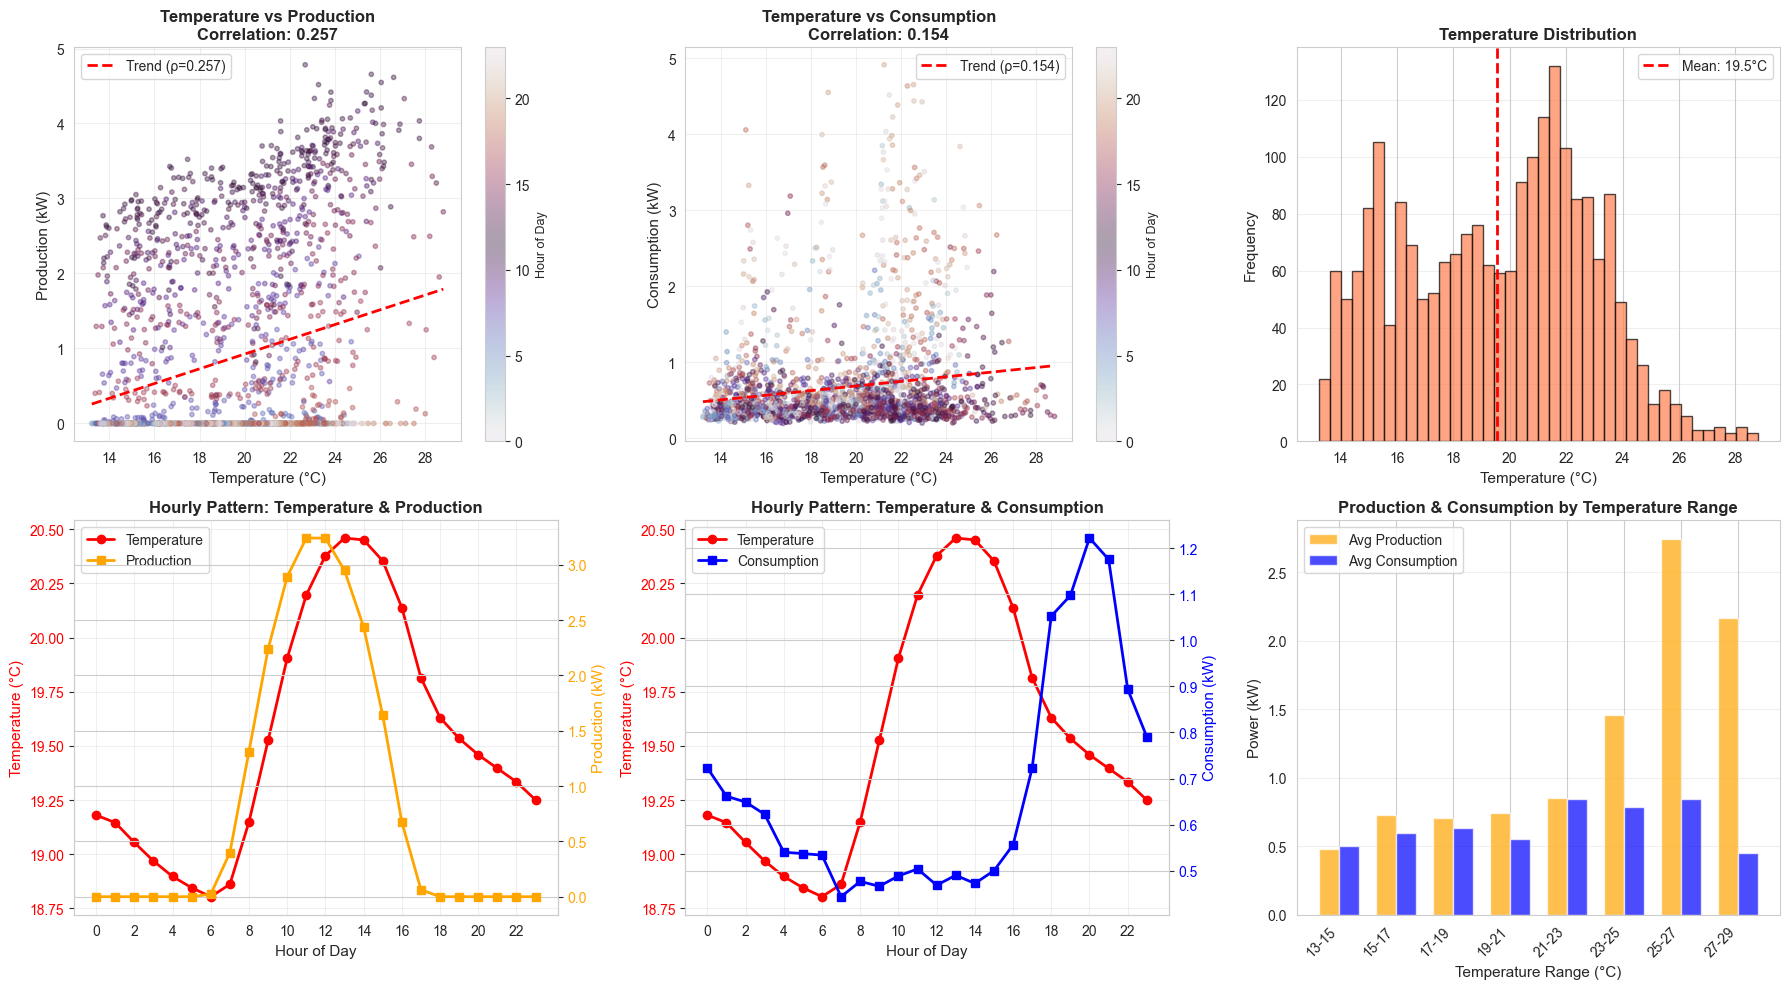

   Temperature vs Production correlation: 0.2572
   Temperature vs Consumption correlation: 0.1538
   Mean temperature: 19.53°C
   Min temperature: 13.22°C
   Max temperature: 28.80°C

   Temperature Range Analysis:
      13-15°C: Prod=0.48kW, Cons=0.50kW
      15-17°C: Prod=0.73kW, Cons=0.60kW
      17-19°C: Prod=0.70kW, Cons=0.63kW
      19-21°C: Prod=0.74kW, Cons=0.55kW
      21-23°C: Prod=0.85kW, Cons=0.85kW
      23-25°C: Prod=1.46kW, Cons=0.79kW
      25-27°C: Prod=2.74kW, Cons=0.85kW
      27-29°C: Prod=2.17kW, Cons=0.45kW


In [19]:
# ============================================================================
# 10. TEMPERATURE CORRELATION ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("10. TEMPERATURE CORRELATION ANALYSIS")
print("=" * 80)

# Load original weather data to get temperature
weather_data = pd.read_csv('../../data/processed_pv_data_2023_2024.csv', 
                           index_col=0, parse_dates=True)

# Merge temperature data with results
df_with_temp = df.merge(
    weather_data[['T2M']], 
    left_on='timestamp', 
    right_index=True, 
    how='left'
)

if 'T2M' in df_with_temp.columns:
    df_with_temp['temperature_c'] = df_with_temp['T2M']
    
    # Calculate correlations
    temp_prod_corr = df_with_temp['temperature_c'].corr(df_with_temp['actual_production_kw'])
    temp_cons_corr = df_with_temp['temperature_c'].corr(df_with_temp['actual_consumption_kw'])
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 10.1 Temperature vs Production scatter
    ax = axes[0, 0]
    scatter = ax.scatter(df_with_temp['temperature_c'], 
                        df_with_temp['actual_production_kw'],
                        c=df_with_temp['hour_of_day'], 
                        cmap='twilight', alpha=0.4, s=10)
    z = np.polyfit(df_with_temp['temperature_c'].dropna(), 
                   df_with_temp['actual_production_kw'].dropna(), 1)
    p = np.poly1d(z)
    temp_range = np.linspace(df_with_temp['temperature_c'].min(), 
                             df_with_temp['temperature_c'].max(), 100)
    ax.plot(temp_range, p(temp_range), "r--", linewidth=2, label=f'Trend (ρ={temp_prod_corr:.3f})')
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Production (kW)', fontsize=11)
    ax.set_title(f'Temperature vs Production\nCorrelation: {temp_prod_corr:.3f}', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Hour of Day', fontsize=9)
    
    # 10.2 Temperature vs Consumption scatter
    ax = axes[0, 1]
    scatter = ax.scatter(df_with_temp['temperature_c'], 
                        df_with_temp['actual_consumption_kw'],
                        c=df_with_temp['hour_of_day'], 
                        cmap='twilight', alpha=0.4, s=10)
    z = np.polyfit(df_with_temp['temperature_c'].dropna(), 
                   df_with_temp['actual_consumption_kw'].dropna(), 1)
    p = np.poly1d(z)
    ax.plot(temp_range, p(temp_range), "r--", linewidth=2, label=f'Trend (ρ={temp_cons_corr:.3f})')
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Consumption (kW)', fontsize=11)
    ax.set_title(f'Temperature vs Consumption\nCorrelation: {temp_cons_corr:.3f}', 
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Hour of Day', fontsize=9)
    
    # 10.3 Temperature distribution
    ax = axes[0, 2]
    ax.hist(df_with_temp['temperature_c'], bins=40, color='coral', alpha=0.7, edgecolor='black')
    ax.axvline(df_with_temp['temperature_c'].mean(), color='red', 
               linestyle='--', linewidth=2, label=f"Mean: {df_with_temp['temperature_c'].mean():.1f}°C")
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title('Temperature Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # 10.4 Hourly temperature vs production pattern
    ax = axes[1, 0]
    hourly_temp = df_with_temp.groupby('hour_of_day')['temperature_c'].mean()
    hourly_prod = df_with_temp.groupby('hour_of_day')['actual_production_kw'].mean()
    ax_twin = ax.twinx()
    line1 = ax.plot(range(24), hourly_temp, marker='o', color='red', 
                    linewidth=2, label='Temperature')
    line2 = ax_twin.plot(range(24), hourly_prod, marker='s', color='orange', 
                         linewidth=2, label='Production')
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Temperature (°C)', color='red', fontsize=11)
    ax_twin.set_ylabel('Production (kW)', color='orange', fontsize=11)
    ax.set_title('Hourly Pattern: Temperature & Production', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='red')
    ax_twin.tick_params(axis='y', labelcolor='orange')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    
    # 10.5 Hourly temperature vs consumption pattern
    ax = axes[1, 1]
    hourly_cons = df_with_temp.groupby('hour_of_day')['actual_consumption_kw'].mean()
    ax_twin = ax.twinx()
    line1 = ax.plot(range(24), hourly_temp, marker='o', color='red', 
                    linewidth=2, label='Temperature')
    line2 = ax_twin.plot(range(24), hourly_cons, marker='s', color='blue', 
                         linewidth=2, label='Consumption')
    ax.set_xlabel('Hour of Day', fontsize=11)
    ax.set_ylabel('Temperature (°C)', color='red', fontsize=11)
    ax_twin.set_ylabel('Consumption (kW)', color='blue', fontsize=11)
    ax.set_title('Hourly Pattern: Temperature & Consumption', fontsize=12, fontweight='bold')
    ax.tick_params(axis='y', labelcolor='red')
    ax_twin.tick_params(axis='y', labelcolor='blue')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))
    
    # 10.6 Temperature bins analysis
    ax = axes[1, 2]
    df_with_temp['temp_bin'] = pd.cut(df_with_temp['temperature_c'], bins=8)
    temp_bin_stats = df_with_temp.groupby('temp_bin').agg({
        'actual_production_kw': 'mean',
        'actual_consumption_kw': 'mean'
    })
    x = np.arange(len(temp_bin_stats))
    width = 0.35
    ax.bar(x - width/2, temp_bin_stats['actual_production_kw'], width, 
           label='Avg Production', color='orange', alpha=0.7)
    ax.bar(x + width/2, temp_bin_stats['actual_consumption_kw'], width, 
           label='Avg Consumption', color='blue', alpha=0.7)
    ax.set_xlabel('Temperature Range (°C)', fontsize=11)
    ax.set_ylabel('Power (kW)', fontsize=11)
    ax.set_title('Production & Consumption by Temperature Range', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{interval.left:.0f}-{interval.right:.0f}' 
                        for interval in temp_bin_stats.index], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print(f"   Temperature vs Production correlation: {temp_prod_corr:.4f}")
    print(f"   Temperature vs Consumption correlation: {temp_cons_corr:.4f}")
    print(f"   Mean temperature: {df_with_temp['temperature_c'].mean():.2f}°C")
    print(f"   Min temperature: {df_with_temp['temperature_c'].min():.2f}°C")
    print(f"   Max temperature: {df_with_temp['temperature_c'].max():.2f}°C")
    
    # Temperature ranges analysis
    print("\n   Temperature Range Analysis:")
    for interval, row in temp_bin_stats.iterrows():
        print(f"      {interval.left:.0f}-{interval.right:.0f}°C: "
              f"Prod={row['actual_production_kw']:.2f}kW, "
              f"Cons={row['actual_consumption_kw']:.2f}kW")
    
    # Update summary with temperature data
    summary['temperature_analysis'] = {
        'temp_prod_correlation': float(temp_prod_corr),
        'temp_cons_correlation': float(temp_cons_corr),
        'mean_temperature_c': float(df_with_temp['temperature_c'].mean()),
        'min_temperature_c': float(df_with_temp['temperature_c'].min()),
        'max_temperature_c': float(df_with_temp['temperature_c'].max())
    }
else:
    print("   ⚠️ Temperature data not found in dataset")

# Combined Energy System Performance Visualization

This section visualizes the key performance indicators of our energy system:
1. Battery State of Charge (SOC) progression
2. Predicted Solar Production
3. Predicted Load Consumption

This combined view helps us understand the relationship between energy production, consumption, and battery management.

In [20]:
# Load required libraries
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load simulation results
simulation_results = pd.read_csv('results/phase_2_offgrid_simulation.csv')
simulation_results['timestamp'] = pd.to_datetime(simulation_results['timestamp'])

# Create the combined plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add battery SOC
fig.add_trace(
    go.Scatter(
        x=simulation_results['timestamp'],
        y=simulation_results['battery_soc_percent'],
        name="Battery SOC (%)",
        line=dict(color='blue', width=2),
        hovertemplate="SOC: %{y:.1f}%<br>Time: %{x}",
    ),
    secondary_y=True,
)

# Add predicted production
fig.add_trace(
    go.Scatter(
        x=simulation_results['timestamp'],
        y=simulation_results['predicted_production_kw'],
        name="Predicted Production (kW)",
        line=dict(color='orange', width=2),
        hovertemplate="Production: %{y:.2f} kW<br>Time: %{x}",
    ),
    secondary_y=False,
)

# Add predicted consumption
fig.add_trace(
    go.Scatter(
        x=simulation_results['timestamp'],
        y=simulation_results['predicted_consumption_kw'],
        name="Predicted Consumption (kW)",
        line=dict(color='red', width=2),
        hovertemplate="Consumption: %{y:.2f} kW<br>Time: %{x}",
    ),
    secondary_y=False,
)

# Add battery operating range indicators
fig.add_hline(y=80, line=dict(color="rgba(0,0,255,0.3)", width=1, dash="dash"), secondary_y=True)
fig.add_hline(y=20, line=dict(color="rgba(0,0,255,0.3)", width=1, dash="dash"), secondary_y=True)

# Update layout
fig.update_layout(
    title="Energy System Performance Overview",
    height=600,
    hovermode="x unified",
    showlegend=True,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

# Update axes titles
fig.update_yaxes(title_text="Power (kW)", secondary_y=False)
fig.update_yaxes(title_text="Battery SOC (%)", secondary_y=True)
fig.update_xaxes(title_text="Time")

# Show plot
fig.show()

ModuleNotFoundError: No module named 'plotly'

# Analysis of Combined Performance

The plot above shows several important aspects of our energy system:

1. **Battery SOC (Blue Line, Right Axis)**
   - Shows the battery charge level over time
   - Operating range bounded by 20% and 80% (dashed lines)
   - Helps identify periods of potential stress on the battery

2. **Predicted Production (Orange Line, Left Axis)**
   - Solar power production forecast
   - Shows daily cycles and weather impacts
   - Helps identify high-production periods

3. **Predicted Consumption (Red Line, Left Axis)**
   - Load consumption forecast
   - Shows usage patterns and peak demand
   - Helps identify high-demand periods

Key Observations:
- When production (orange) exceeds consumption (red), the battery SOC (blue) typically increases
- When consumption exceeds production, the battery SOC decreases
- The system tries to maintain the battery SOC between 20% and 80% for optimal operation
- Blackout risks are highest when consumption is high, production is low, and battery SOC is near 20%

In [21]:
# Calculate and display some key metrics
metrics = {
    'Average Battery SOC (%)': simulation_results['battery_soc_percent'].mean(),
    'Min Battery SOC (%)': simulation_results['battery_soc_percent'].min(),
    'Max Battery SOC (%)': simulation_results['battery_soc_percent'].max(),
    'Average Daily Production (kWh)': simulation_results['predicted_production_kw'].resample('D', on='timestamp').sum().mean(),
    'Average Daily Consumption (kWh)': simulation_results['predicted_consumption_kw'].resample('D', on='timestamp').sum().mean(),
    'Total Blackout Hours': simulation_results['is_blackout'].sum(),
    'Blackout Rate (%)': (simulation_results['is_blackout'].sum() / len(simulation_results)) * 100
}

# Print metrics in a formatted way
print("\nKey Performance Metrics:")
print("=" * 50)
for metric, value in metrics.items():
    print(f"{metric:30s}: {value:,.2f}")

NameError: name 'simulation_results' is not defined